## Maintaining State in LLMs with JSON Objects

### Intro

In this document , we will try to examine the state problem and the related research in LLMs together with a little Jupyter code example .The notebook part demonstrates how to simulate statefulness in a stateless LLM by using **JSON patches** to maintain a structured state object. We simplify the scenario to only track `ingredients_include` in a recipe recommendation flow.
 

Large Language Models (LLMs) are stateless by design – they have no long-term memory of past interactions
. Each query is handled independently, and the only “memory” an LLM has is the text (context) provided in the prompt. This stateless nature can be limiting for applications like chatbots or assistants that need to recall previous inputs.
. To overcome this, developers have devised ways to maintain state externally and feed it back to the LLM on each turn. One effective approach is using JSON objects to represent and persist the conversation state between LLM calls
. This allows the LLM to work with structured data, ensuring important details are not lost between prompts.

### Stateless vs. Stateful Interactions

In a stateless interaction, each LLM response depends only on the current prompt (which may include some recent history). The model doesn’t inherently remember past exchanges beyond the provided context
. For example, if you ask an LLM a question and then follow up with a related question, the model will only connect them if the conversation history is included in the new prompt. Without explicit memory, it might forget key facts you provided earlier. By contrast, a stateful interaction simulates memory by carrying forward information from previous turns. A straightforward way is to append the conversation history to each prompt (as frameworks like LangChain do, storing past messages)
. However, raw text history can become unwieldy and it relies on the model to parse the entire context every time. Additionally, the model might produce unpredictable results or ask irrelevant questions if it’s left to freely decide what to remember
. This is where a structured state representation can help.

### Using JSON to Represent State

JSON (JavaScript Object Notation) is a lightweight, structured data format that LLMs can both read and write. By keeping a JSON state object, we can maintain key information in a well-defined schema across turns. The idea is to update this JSON as the conversation progresses and feed it back into the LLM with each prompt. Because the JSON has a fixed structure (fields and types), it acts as an explicit memory for the LLM, reducing ambiguity. A pioneering example of this approach comes from a deeplearning.ai tutorial on building a text-based game. The game maintains a JSON state representing things like the player’s inventory. Each user action triggers the LLM twice in a loop: first to extract the state change (in JSON) caused by the action, and second to respond to the user using the updated state. For instance, if the player picks up a stone, the LLM’s first response might be a JSON indicating {"change": "set", "field": "inventory.stone", "value": 1} (meaning add one stone to inventory). The system then updates the state JSON and calls the LLM again to describe the result (e.g. “You picked up a stone.”). If the player later tries to throw a stone they don’t have, the LLM can check the state (stone count zero) and respond accordingly (e.g. “You don’t have any stone to throw.”). This structured loop ensures the LLM’s responses stay consistent with the evolving state of the game.

### Structured State in a Conversational Assistant
The same principle can be applied to real-world assistant applications. Consider a job application assistant that helps a user prepare a CV and cover letter. Such an assistant needs to gather a lot of information (user’s education, work experience, the target job details, etc.) across multiple turns. Using a JSON state object, the assistant can keep track of all the information the user provides in a structured way
. For example, the JSON state might have fields like {"personal_info": {...}, "experience": [...], "vacancy": {...}}. The interaction can be managed in two steps repeatedly:
State Update Step: The LLM receives the user’s latest input along with the current state (as JSON) and is asked to output only the changes to the state in JSON format. For instance, if the user says “I have 7 years of software development experience, including working at Capgemini.”, the LLM might output a JSON like:

{
  "changes": [
    {"change": "append", "field": "experience.previous_roles", 
     "value": {"title": "Software Engineer", "company": "Capgemini", "years": 7, "description": "Worked on various projects"}}
  ]
}

This JSON indicates a new previous role to add to the experience list. The application code can parse this and update the state object accordingly (using a schema ensures we know exactly where to put this info).
Next Question/Action Step: The updated state JSON is then passed back to the LLM with a prompt asking what is needed next. Based on the state, the LLM formulates the next question for the user or declares it has enough information. For example, after adding the job experience above, the assistant might ask, “What is the title of the position you are applying for at Luminis?” – because it sees that the vacancy.title field in the state is still empty.

Overview of a stateful LLM interaction loop. The figure illustrates a multi-turn loop for managing state. First, the user’s input (“I want to apply for a job at Luminis”) triggers an Extract Change prompt to the LLM, which returns a JSON { change } describing how to update the state (e.g. set vacancy.company = "Luminis"). Next, the system applies that change to the state JSON and uses the updated state in a Next Question prompt. The LLM, seeing the new state, asks a follow-up question (“What is the title of the position you are applying for at Luminis?”) to gather more info. This loop continues until the state is complete, at which point the assistant can use the full state to generate the final CV or answer. By using a JSON state, the assistant avoids asking redundant or irrelevant questions. It has a clear picture of what information is already obtained and what is missing. This structured approach yields more predictable and consistent interactions compared to an open-ended Q&A, since the LLM is guided to focus on filling specific fields in the JSON.

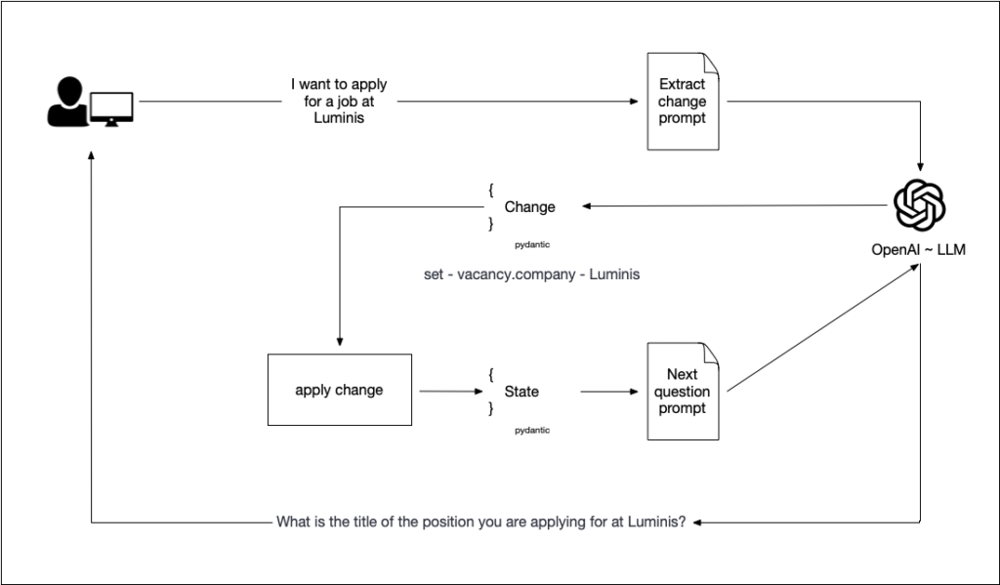

### Enforcing Structured JSON Output
A key challenge in this approach is getting the LLM to reliably output valid JSON that matches the expected schema. Free-form LLM outputs can easily include extra text, formatting errors, or omissions. In the past, prompt engineering hacks were needed (like saying “Output only JSON” or providing examples), which were not always dependable. Generating perfectly structured JSON has been so important that OpenAI introduced a special “JSON mode” (via function calling/structured outputs) to constrain models to return valid JSON objects. Researchers have even developed advanced decoding techniques (e.g. using finite state machines) to ensure local LLMs stick to a given JSON schema during generation. Today, new features and libraries make structured output much easier. For example, the OpenAI API (2023+) allows developers to define functions or JSON schemas that the model should adhere to, and the model will return a JSON-compliant result that fits the schema. Similarly, Ollama (an open-source LLM runner) introduced a structured outputs feature in late 2024, enabling schema-constrained generation for local models. With Ollama’s API or client library, you can send a JSON Schema along with your prompt, and the model will only output data that fits that schema. This yields far more reliable results than hoping the model follows instructions on its own. For instance, using Ollama’s structured output, if you ask “Tell me about Canada.” and specify a schema with fields "name", "capital", and "languages" (all strings or list of strings), the model will return something like:
{
  "name": "Canada",
  "capital": "Ottawa",
  "languages": ["English", "French"]
}
Exactly as requested, with no extra commentary. Behind the scenes, the system ensures the LLM’s output conforms to the JSON structure (it might use techniques like logit bias or post-processing to fix brackets, etc., as hinted by research
). From the developer’s perspective, it feels like the model “knows” the schema. In reality, it’s guided to produce only allowed tokens that keep the output valid. Using Python data models (e.g. Pydantic in Python), we can define the expected schema as a class and pass it to the LLM API. The OpenAI and Ollama clients will then handle validation and even give you a parsed object directly. This means the JSON state can be turned into a type-safe object in your code with ease. One blog describes how they used a Pydantic State class to get a parsed response from GPT-4 and update the state, rather than manually parsing JSON strings. The same can be done with Ollama – the schema can be serialized via BaseModel.model_json_schema() and sent in the request, and the response can be validated with BaseModel.model_validate_json() to get a Python object. This greatly simplifies working with the JSON state. Benefits: Forcing the LLM to output JSON following a defined schema offers several advantages:
- Reliability: The output format is guaranteed (or at least validated) to be correct JSON with the expected fields, eliminating parsing errors
- Focus: The LLM’s attention is focused on just the data for the JSON fields, not on producing verbose text. This avoids extraneous explanations and keeps the conversation on track.
- Integration: The structured output can be directly fed into other systems or functions. For example, once the state JSON is complete, it could be passed to a function that actually generates a formatted CV, or in a recipe app, used to query a recipe database. Because the schema is known, other software components can consume it confidently.
- Memory Efficiency: Instead of storing entire dialogue history, you only store the essential information in the JSON. This state object can be much more compact and semantically meaningful than raw text logs.
- Clarity for the User: If desired, the JSON (or its contents) can even be shown to the user for confirmation or editing (since it’s structured). This bridges a form-filling style interaction with natural language.

Of course, careful prompt design is still needed – the LLM should be instructed (usually via a system message or few-shot examples) how to decide on state changes or what each field means. In our job application example, the system prompt explicitly listed the JSON schema for the state and told the LLM to output any changes in that JSON format. Having a well-defined schema upfront acts as a contract between the user, the LLM, and the application, making the multi-turn interaction much more deterministic. It’s also important to use appropriate decoding settings for structured output. Typically, a low temperature (0 or near 0) is used so that the model doesn’t get “creative” with formatting. The goal is to have it follow the schema strictly, which is easier when it’s deterministically choosing the most likely next token (often the correct punctuation or field name) rather than exploring variations. This best practice is often recommended when generating code or structured data with LLMs.

### Research and Developments
The idea of constraining LLM outputs to a format has gained traction in the research community. Beyond OpenAI’s function calling, researchers have proposed methods like Outlines (OpenAI, 2023) which convert a JSON Schema into a regular expression and then into a finite state machine (FSM) to guide the model’s token-by-token generation
. By filtering out tokens that would break the JSON format at each step, an FSM-based decoder can ensure well-formed output. A recent blog post by LMSys Org demonstrated an optimized “jump-forward” decoding algorithm that uses compressed FSMs to speed up this constrained generation, making it even faster than normal decoding in some cases. These advances underline the importance of structured outputs in practical LLM applications. On the applied side, frameworks are emerging to simplify structured prompting. For example, the Instructor library provides an interface to use Pydantic models directly with local LLMs like Ollama’s Llama 2, and will handle retries or timeouts while expecting a certain schema. Such tools wrap the logic of calling the model and validating the response, so developers can focus on defining the data model (state) and the conversation logic. Also notable is that vision-capable models can output structured JSON descriptions of images. In Ollama’s blog example, a vision model (llama3.2-vision) was prompted to describe an image, and it returned a JSON with fields like summary, objects, scene, colors. This indicates that the structured output approach isn’t limited to pure text scenarios – any domain where you need the model to return structured data (extracted info, metadata, etc.) can benefit from these techniques. Finally, community experiences (e.g. on forums like Reddit) have shown that with careful setup – such as fine-tuning models or using special system prompts – even local LLaMA models can output correct JSON consistently. In fact, some versions of LLaMA models have been fine-tuned or configured (like llama3_8b_json in one user’s case) to better adhere to JSON formatting expectations. The takeaway is that structured output is becoming a standard feature of modern LLM tooling, enabling statefulness and data integrity in AI applications.

### Conclusion

Using JSON objects to maintain state in LLM-driven applications marries the flexibility of natural language with the rigor of structured data. It allows us to **master state in stateless LLMs** by externalizing the memory into a format both machines and humans understand. 

Blog posts and tutorials have shown that this approach, combined with new API features, enables more reliable and controllable AI interactions ([luminis.eu](https://www.luminis.eu/blog/mastering-state-in-stateless-llm/), [python.useinstructor.com](https://python.useinstructor.com)). By iteratively updating a JSON state and leveraging structured output modes, we can build complex conversational flows—from game state tracking to personal assistants—that remain coherent and goal-directed. 

This technique is rapidly becoming a best practice for developing **robust, stateful LLM applications** that are easier to test, debug, and integrate with other systems ([medium.com](https://medium.com)). With ongoing research into constrained decoding and tools that support JSON schemas out-of-the-box, we can expect LLMs to handle structured state even more seamlessly in the future.

---

### Sources

- J. Coenradie, “Mastering State in Stateless LLMs,” [Luminis Blog](https://www.luminis.eu/blog/mastering-state-in-stateless-llm/), Dec. 2024  
- J. Coenradie, GitHub Repository – [stateful-llm example code](https://github.com/jettro/statefull-llm), 2024  
- Ollama Team, “Structured outputs,” [Ollama Blog](https://ollama.com/blog/structured-output), Dec. 6, 2024  
- L. Yin et al., “Fast JSON Decoding for Local LLMs with Compressed FSM,” [LMSys Blog](https://lmsys.org/blog/2024-fast-json/), Feb. 2024  
- M. Madhavan, “Giving Memory to Stateless LLMs Using LangChain,” [Medium](https://medium.com), Mar. 17, 2025  
- Alejandro, “Structured output with Llama from scratch,” [Medium](https://medium.com), Oct. 4, 2024  
- YouTube Tutorial – [How to get structured JSON outputs from local LLMs (Ollama & LLaMA 3.2)](https://python.useinstructor.com)


In [10]:
from pydantic import BaseModel
from typing import List, Literal, Union
from copy import deepcopy
from ollama import chat

class SimpleState(BaseModel):
    ingredients_include: List[str] = []

class PatchOperation(BaseModel):
    op: Literal["append", "remove"]
    field: Literal["ingredients_include"]
    value: List[str]

class PatchList(BaseModel):
    changes: List[PatchOperation]



In [11]:
def get_patch_from_llm(user_input: str, state: SimpleState) -> List[PatchOperation]:
    system_prompt = f"""
You are a JSON patch assistant for a recipe search engine.

Your task is:
- Read the user's message.
- Compare it to the current state.
- Output ONLY patch operations for the 'ingredients_include' field.
- NEVER guess ingredients. ONLY include/remove ingredients that the user clearly states.

Patch format:
{{"changes": [{{"op": "append"|"remove", "field": "ingredients_include", "value": [ingredient1, ingredient2, ...] }}]}}

Current state:
{state.model_dump_json(indent=2)}

User message:
\"\"\"{user_input}\"\"\"

Output the PATCHES:
"""

    response = chat(
        model="llama3.2",
        messages=[{"role": "system", "content": system_prompt}],
        format=PatchList.model_json_schema(),
        options={"temperature": 0}
    )

    return PatchList.model_validate_json(response["message"]["content"]).changes

In [12]:
def apply_patch(state: SimpleState, patches: List[PatchOperation]) -> SimpleState:
    updated = deepcopy(state)
    for patch in patches:
        if patch.op == "append":
            for item in patch.value:
                if item not in updated.ingredients_include:
                    updated.ingredients_include.append(item)
        elif patch.op == "remove":
            updated.ingredients_include = [
                ing for ing in updated.ingredients_include if ing not in patch.value
            ]
    return updated


In [13]:
state = SimpleState()
user_inputs = [
    "I want chicken and mushrooms.",
    "Add tomatoes too.",
    "Actually remove chicken."
]

for user_input in user_inputs:
    print("User:", user_input)
    patch = get_patch_from_llm(user_input, state)
    state = apply_patch(state, patch)
    print("Updated state:", state.model_dump_json(indent=2))
    print("-" * 40)


User: I want chicken and mushrooms.
Updated state: {
  "ingredients_include": [
    "chicken",
    "mushrooms"
  ]
}
----------------------------------------
User: Add tomatoes too.
Updated state: {
  "ingredients_include": [
    "chicken",
    "mushrooms",
    "tomatoes"
  ]
}
----------------------------------------
User: Actually remove chicken.
Updated state: {
  "ingredients_include": [
    "mushrooms",
    "tomatoes"
  ]
}
----------------------------------------
